# ECS 174 HW1

In [ ]:
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

In [ ]:
# show and save a ndarray as an image
def img_save(img_array, file_name, title= '', show = True, cmap=None, dtype = np.uint8):

    if show:
        plt.imshow(img_array.astype(dtype), cmap = cmap)
        plt.title(title)
        plt.show()

    plt.imsave(file_name, img_array.astype(dtype), cmap = cmap)

In [ ]:
def convolve(img: np.array, kernel: np.array, dtype = np.uint8) -> np.array:
    image = np.asarray(img, dtype = dtype)
    if len(image.shape) == 3:
        filter_size = kernel.shape[0]
        img_padded = np.pad(image, pad_width=((filter_size // 2, filter_size // 2), (filter_size // 2, filter_size // 2), (0, 0)), mode='constant', constant_values=0).astype(np.float32)
        finale = np.zeros_like(image)
        for x in range(image.shape[0]):
            if x > image.shape[0]:
                break
            for y in range(image.shape[1]):
                if y > image.shape[1]:
                    break
                r = np.sum(np.multiply(img_padded[x : x + filter_size, y : y + filter_size, 0], kernel))
                g = np.sum(np.multiply(img_padded[x : x + filter_size, y : y + filter_size, 1], kernel))
                b = np.sum(np.multiply(img_padded[x : x + filter_size, y : y + filter_size, 2], kernel))
                finale[x, y] = (r, g, b)
        return finale
    elif len(image.shape) == 2:
        filter_size = kernel.shape[0]
        img_padded = np.pad(image, pad_width=((filter_size // 2)), mode='constant', constant_values=0).astype(dtype)
        finale = np.zeros_like(image)
        for x in range(image.shape[0]):
            if x > image.shape[0]:
                break
            for y in range(image.shape[1]):
                if y > image.shape[1]:
                    break
                pixel = np.sum(np.multiply(img_padded[x : x + filter_size, y : y + filter_size], kernel))
                finale[x, y] = pixel
        return finale
    else:
        raise WindowsError

## Q1

In [ ]:
def GaussianBlurImage(image, sigma):
    sigma = 4.0
    filter_size = 2 * int(4 * sigma + 0.5) + 1
    gaussian_filter = np.zeros((filter_size, filter_size), np.float32)

    # making gaussian filter
    for i in range(filter_size):
        for j in range(filter_size):
            x = i - filter_size // 2
            y = j - filter_size // 2
            gaussian_filter[i, j] = 1 / (2 * np.pi * sigma ** 2) * np.exp(-(x ** 2 + y ** 2)/(2 * sigma ** 2))

    finale = convolve(image, gaussian_filter)

    return finale


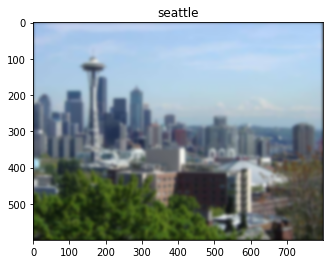

In [ ]:
img_seattle = Image.open("./hw1_data/Seattle.jpg") # replace path
img_1 = GaussianBlurImage(img_seattle, sigma=4.0)
img_save(img_1, "1.jpg", "seattle", True)

## Q2

In [ ]:
def SeparableGaussianBlurImage(image, sigma, dtype = np.uint8):
    sigma = 4.0
    filter_size = 2 * int(4 * sigma + 0.5) + 1
    gaussian_filter_x = np.zeros((filter_size, filter_size), dtype)
    gaussian_filter_y = np.zeros((filter_size, filter_size), dtype)

    # making gaussian filter
    for j in range(filter_size):
        x = j - filter_size // 2
        gaussian_filter_x[j, filter_size//2] = ((1 / np.sqrt(2 * np.pi * sigma ** 2) * np.exp(-(x ** 2)/(2 * sigma ** 2))))
        gaussian_filter_y[filter_size//2, j] = ((1 / np.sqrt(2 * np.pi * sigma ** 2) * np.exp(-(x ** 2)/(2 * sigma ** 2))))

    finale = convolve(image, gaussian_filter_x, dtype)
    finale = convolve(image, gaussian_filter_y, dtype)

    return finale

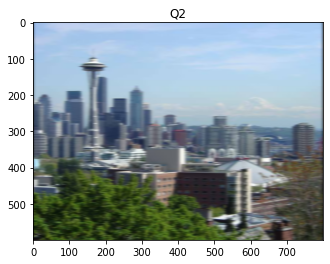

In [ ]:
img_2 = SeparableGaussianBlurImage(img_seattle, sigma=4.0, dtype=np.float32)
img_save(img_2, '2.png', 'Q2', show = True)

## Q3

In [ ]:
# Q3
def SharpenImage(image, sigma, alpha):
    img = np.asarray(image, dtype = np.float32)
    smoothBrain = GaussianBlurImage(image, sigma)
    img_sharpen = np.subtract(img, (alpha * np.subtract(smoothBrain, img)))
    return np.clip(img_sharpen, a_min=0, a_max=255)

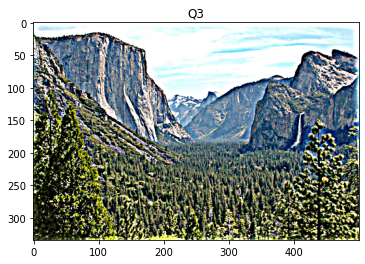

In [ ]:
img_yosemite = Image.open('./hw1_data/Yosemite.png') ##
img_3 = SharpenImage(img_yosemite, sigma=1.0, alpha=5.0)
img_save(img_3, '4.png', 'Q3', show = True)

## Q4

In [ ]:
# Q4
def SobelImage(image):
    g_x =  np.array([[-1, 0, 1],
                     [-2, 0, 2],
                     [-1, 0, 1]])
    g_y =  np.array([[-1, -2, -1],
                     [0, 0, 0],
                     [1, 2, 1]])

    img_seattle = Image.open("./hw1_data/LadyBug.jpg").convert("L")

    Limage = convolve(img_seattle, g_x, dtype=np.float32)
    Aimage= convolve(img_seattle, g_y, dtype=np.float32)

    magnitude = np.sqrt(Aimage**2 + Limage**2)
    orientation = np.arctan2(Aimage, Limage)

    return magnitude, orientation

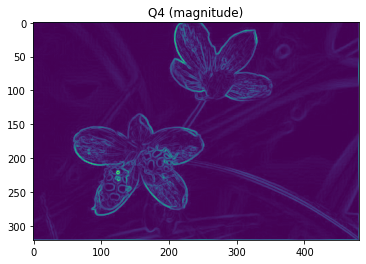

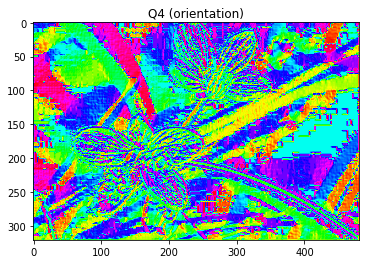

In [ ]:
img_ladybug = Image.open('hw1_data/LadyBug.jpg') ##
magnitude, orientation = SobelImage(img_ladybug)
img_save(magnitude, '5a.png', 'Q4 (magnitude)', show = True, dtype = np.float32)
img_save(orientation, '5b.png', 'Q4 (orientation)', show = True, cmap = plt.cm.hsv, dtype = np.float32)

## Q5

In [ ]:
def UpSampling(image, factor, interpolation):
    image = np.asarray(image, dtype=np.uint8)

    width_up = image.shape[0]*factor
    height_up = image.shape[1]*factor

    img_upsampled = np.zeros((height_up, width_up, image.shape[2]), dtype = np.uint8)

    if interpolation == "NN":
        for i in range(height_up):
            for j in range(width_up):
                x = i//factor
                y = j//factor
                if x >= image.shape[0]:
                    x = image.shape[0] - 1
                if y >= image.shape[1]:
                    y = image.shape[1] - 1
                img_upsampled[i][j] = image[x][y]
    elif interpolation == "Bilinear":
        for i in range(height_up):
            for j in range(width_up):
                x = i/factor
                y = j/factor
                if x >= image.shape[0] - 1:
                    x = image.shape[0] - 2
                if y >= image.shape[1] - 1:
                    y = image.shape[1] - 2
                a = x - np.floor(x)
                b = y - np.floor(y)
                x = int(np.floor(x))
                y = int(np.floor(y))
                img_upsampled[i][j] = (1 - a)*(1 - b)*(image[x,y]) + (a)*(1 - b)*(image[x + 1, y]) + (1 - a)*(b)*(image[x][y + 1]) + (a)*(b)*(image[x + 1][y + 1])

    return img_upsampled

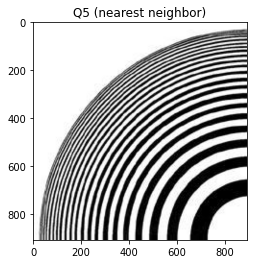

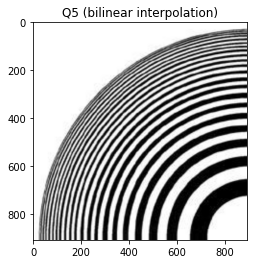

In [ ]:
img_moire = Image.open('./hw1_data/Moire_small.jpg') ##
moire_nn = UpSampling(img_moire, factor=4, interpolation="NN")
moire_bilinear = UpSampling(img_moire, factor=4, interpolation="Bilinear")
img_save(moire_nn, '6a.png', 'Q5 (nearest neighbor)', show = True, dtype = np.uint8)
img_save(moire_bilinear, '6b.png', 'Q5 (bilinear interpolation)', show = True, dtype = np.uint8)